In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data, wb
import scipy.optimize as sco
import scipy.interpolate as itp

In [2]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


In [3]:
symbols = [u'ED', u'PLUS', u'ERI', u'FTAI']
noa = len(symbols)

In [4]:
from datetime import datetime, timedelta
N = 200
days_ago_N = datetime.now() - timedelta(days=N)
days_ago_N_string = days_ago_N.strftime('%Y-%m-%d')

In [5]:
%%time
df = pd.DataFrame()
start = days_ago_N_string
for symbol in symbols:
    print(symbol)
    df[symbol] = data.DataReader(symbol, 'google', start)['Close']

ED
PLUS
ERI
FTAI
Wall time: 1.42 s


In [6]:
df.head()

,ED,PLUS,ERI,FTAI
Date,,,,
2016-11-03,73.87,45.30,11.05,12.45
2016-11-04,73.75,48.85,10.80,12.92
2016-11-07,74.54,48.88,10.80,13.49
2016-11-08,75.33,47.68,11.30,13.10
2016-11-09,72.26,48.45,11.65,13.04


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


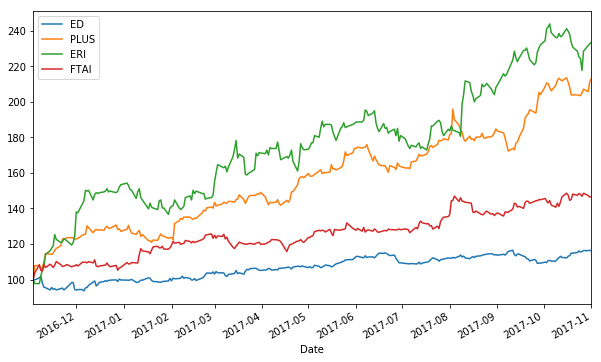

In [7]:
(df / df.ix[0] * 100).plot(figsize=(10,6))

In [8]:
rets = np.log(df / df.shift(1))

In [9]:
df

,ED,PLUS,ERI,FTAI
Date,,,,
2016-11-03,73.87,45.30,11.05,12.45
2016-11-04,73.75,48.85,10.80,12.92
2016-11-07,74.54,48.88,10.80,13.49
2016-11-08,75.33,47.68,11.30,13.10
2016-11-09,72.26,48.45,11.65,13.04
2016-11-10,70.69,49.80,11.95,13.49
2016-11-11,70.49,52.00,12.60,13.29
2016-11-14,69.55,51.80,12.85,13.52
2016-11-15,70.57,51.72,13.00,13.43


In [10]:
rets.mean() * 252

ED      0.150910
PLUS    0.762286
ERI     0.854728
FTAI    0.385504
dtype: float64

In [11]:
rets.cov() * 252

,ED,PLUS,ERI,FTAI
ED,0.018424,-0.004473,-0.006596,-0.000755
PLUS,-0.004473,0.055420,0.013749,0.003872
ERI,-0.006596,0.013749,0.113211,-0.001632
FTAI,-0.000755,0.003872,-0.001632,0.041756


In [12]:
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([ 0.21461796,  0.07822367,  0.65730674,  0.04985163])

In [13]:
np.dot(weights.T, rets.mean()) * 252

0.67305300439385429

In [14]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.049514256185010763

In [15]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.22251799069965278

In [16]:
prets = []
pvols = []
for p in range(2500):
    weights = np.random.random(noa)
    weights = weights / np.sum(weights)
    prets.append(np.dot(weights.T, rets.mean() * 252))
    pvols.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))))
    
prets = np.array(prets)
pvols = np.array(pvols)

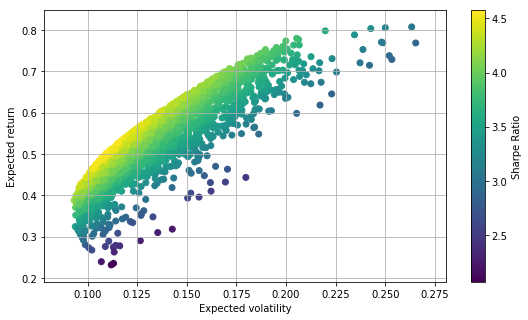

In [17]:
plt.figure(figsize=(9, 5))
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
plt.grid(True)
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe Ratio')

In [18]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.dot(weights.T, rets.mean() * 252)
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

In [19]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [20]:
cons = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0,1) for x in range(noa))

In [21]:
%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)

Wall time: 34 ms


In [22]:
opts

     fun: -4.579505109100806
     jac: array([  2.17628479e-03,   2.87294388e-05,  -1.84500217e-03,
        -2.11745501e-03])
 message: 'Optimization terminated successfully.'
    nfev: 41
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([ 0.33368064,  0.2975978 ,  0.16512277,  0.20359878])

In [23]:
def calc_weights(BP, xs, df):
    t = BP / np.dot(df.tail(1), xs)
    out = zip(symbols, t * xs)
    out = sorted(out, key=lambda tup: tup[1], reverse=True)
    return out

In [24]:
out = calc_weights(484.00, opts.x, df)
print out
print [sym[0] for sym in out if sym[1] > 0.00001]

[(u'ED', 2.4723202119221046), (u'PLUS', 2.2049737644700116), (u'FTAI', 1.5085123581756812), (u'ERI', 1.2234343801946175)]
[u'ED', u'PLUS', u'FTAI', u'ERI']


In [25]:
df.tail(1)

,ED,PLUS,ERI,FTAI
Date,,,,
2017-11-01,85.8,96.5,25.8,18.25
